## In This Project I'm going to build a model that predicts whether the person is a diabetic or not , I feel like its an importent project cause more than 40% of people will suffer from some degree of diabetes in their life

## I'm Going to import the libraries i need for the Project first

In [1]:
## Main Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import warnings
import missingno
warnings.filterwarnings('ignore')
## sklearn -- preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn_features.transformers import DataFrameSelector
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
#import GridSearchCV
from sklearn.model_selection import GridSearchCV

## sklearn -- models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

## skelarn -- metrics
from sklearn.metrics import f1_score

## Read the Dataset

In [2]:
TRAIN_DATA_PATH = os.path.join(os.getcwd(), 'diabetes.csv')
df = pd.read_csv(TRAIN_DATA_PATH)

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
## Check info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## All The Features Seems Fine according to its data type but we may need to add more features which might improve the model performance

In [4]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## Right away we can that some of the features have '0' Value Which doesn't make sense because Glucose,Pressure,insulin,bmi cant be zero or the person will die so i will replace the Zero with a Nan value which we can impute later on


In [5]:
diabetes_data = df.copy(deep = True)
diabetes_data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = diabetes_data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [6]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## Okay so the zero values have been successfully remove now lets check the Nans and Dist

In [7]:
diabetes_data.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

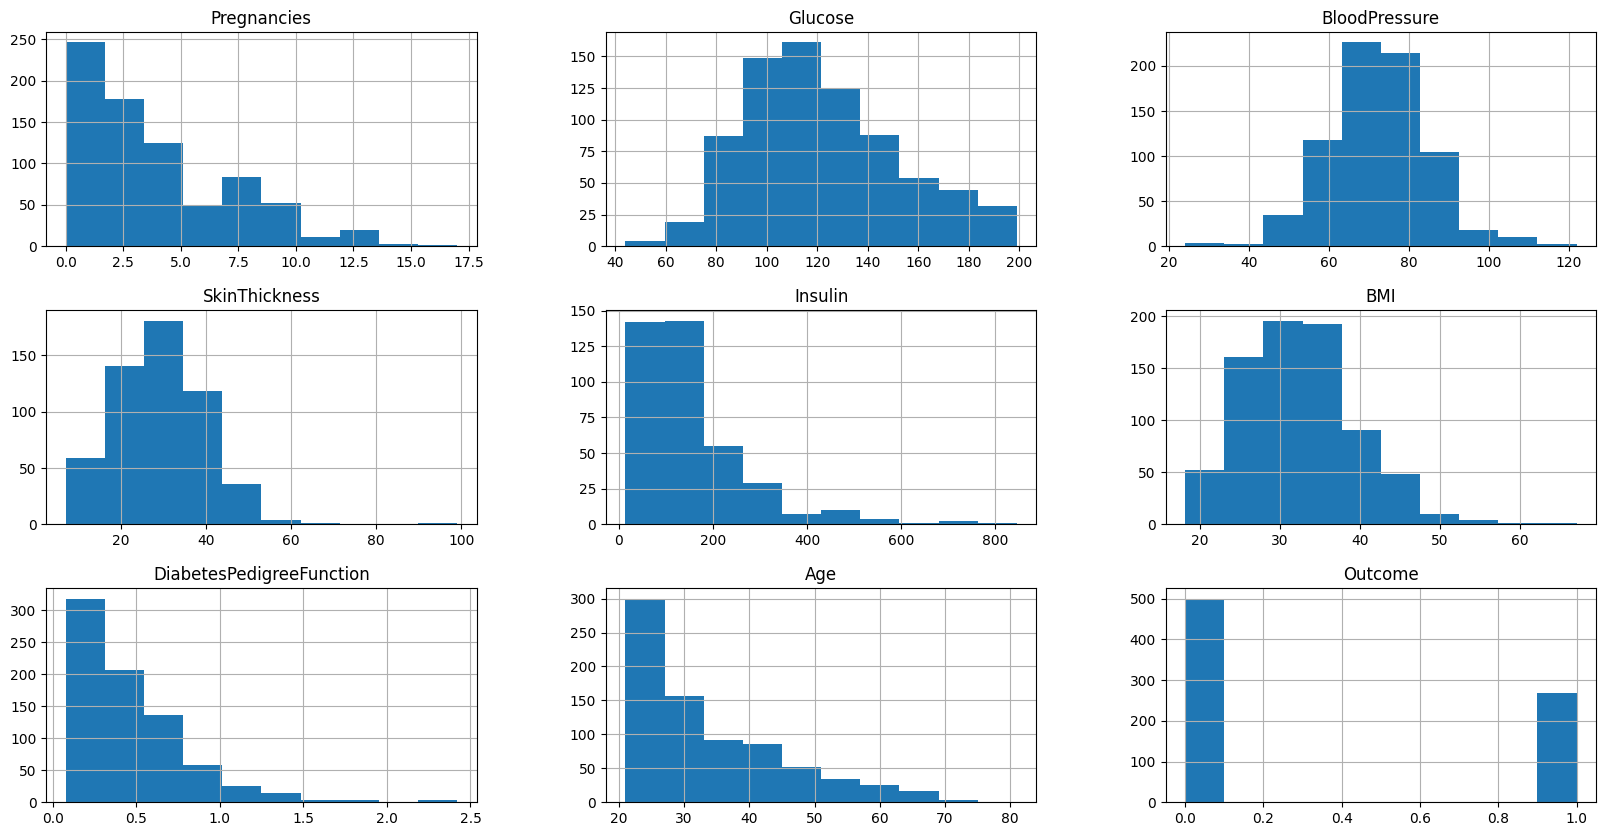

In [8]:
diabetes_data.hist(figsize=(20,10))
plt.show()

## The Distrubtion Looks fine with little to no outliers so i'm going to impute the NaN Values with thier appropiate impute ('Median or Mean') according to their Disturbtion instead of using the pipeline

In [9]:
diabetes_data['Glucose'].fillna(diabetes_data['Glucose'].mean(), inplace = True)
diabetes_data['BloodPressure'].fillna(diabetes_data['BloodPressure'].mean(), inplace = True)
diabetes_data['SkinThickness'].fillna(diabetes_data['SkinThickness'].median(), inplace = True)
diabetes_data['Insulin'].fillna(diabetes_data['Insulin'].median(), inplace = True)
diabetes_data['BMI'].fillna(diabetes_data['BMI'].median(), inplace = True)

## Disturbtion After The Imputing

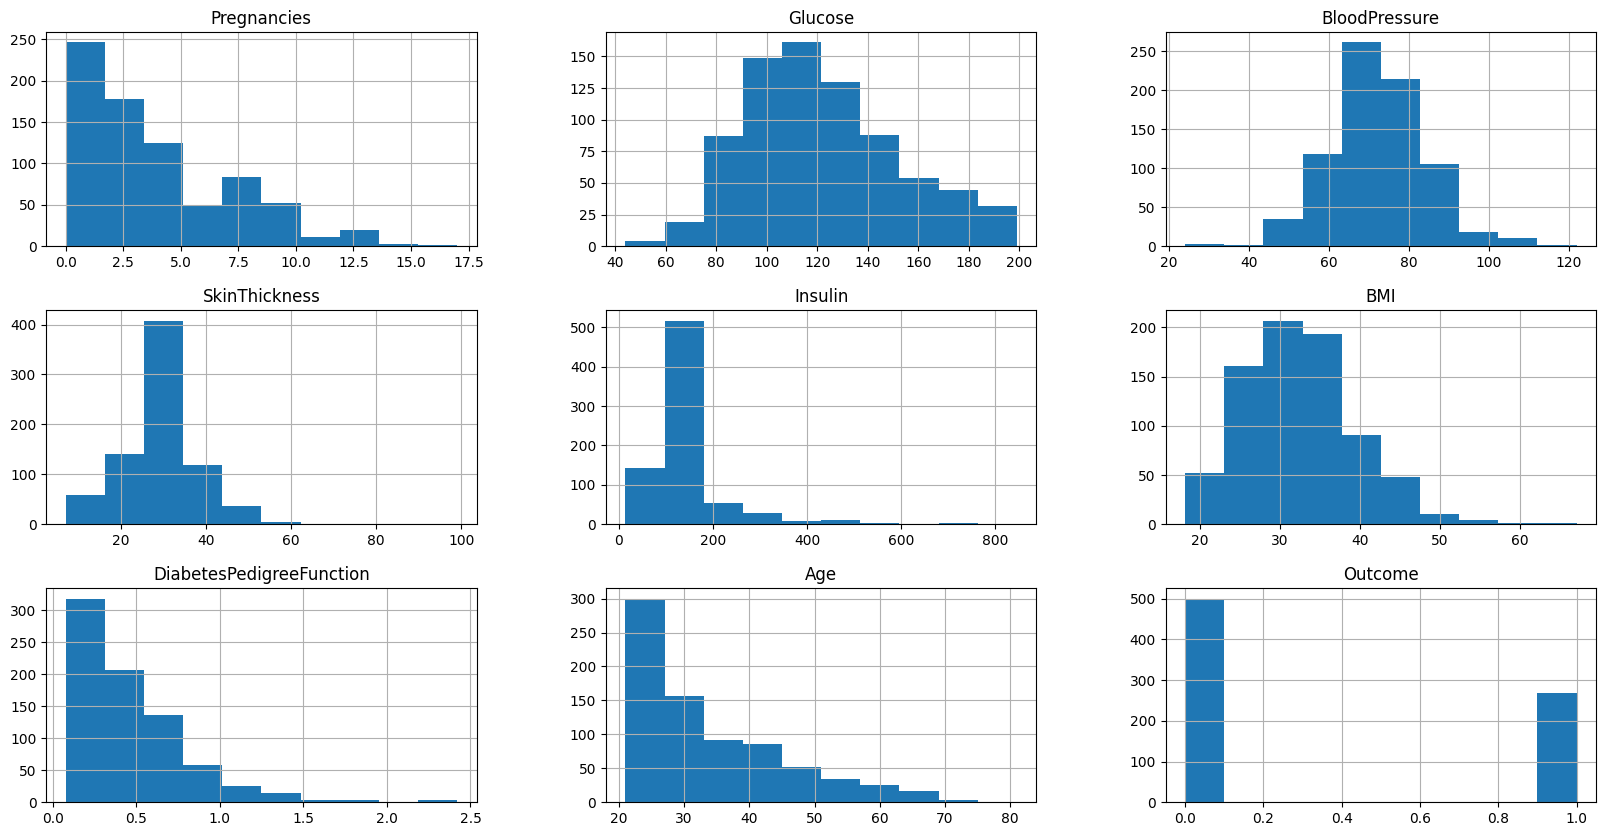

In [10]:
diabetes_data.hist(figsize=(20,10))
plt.show()

<Axes: >

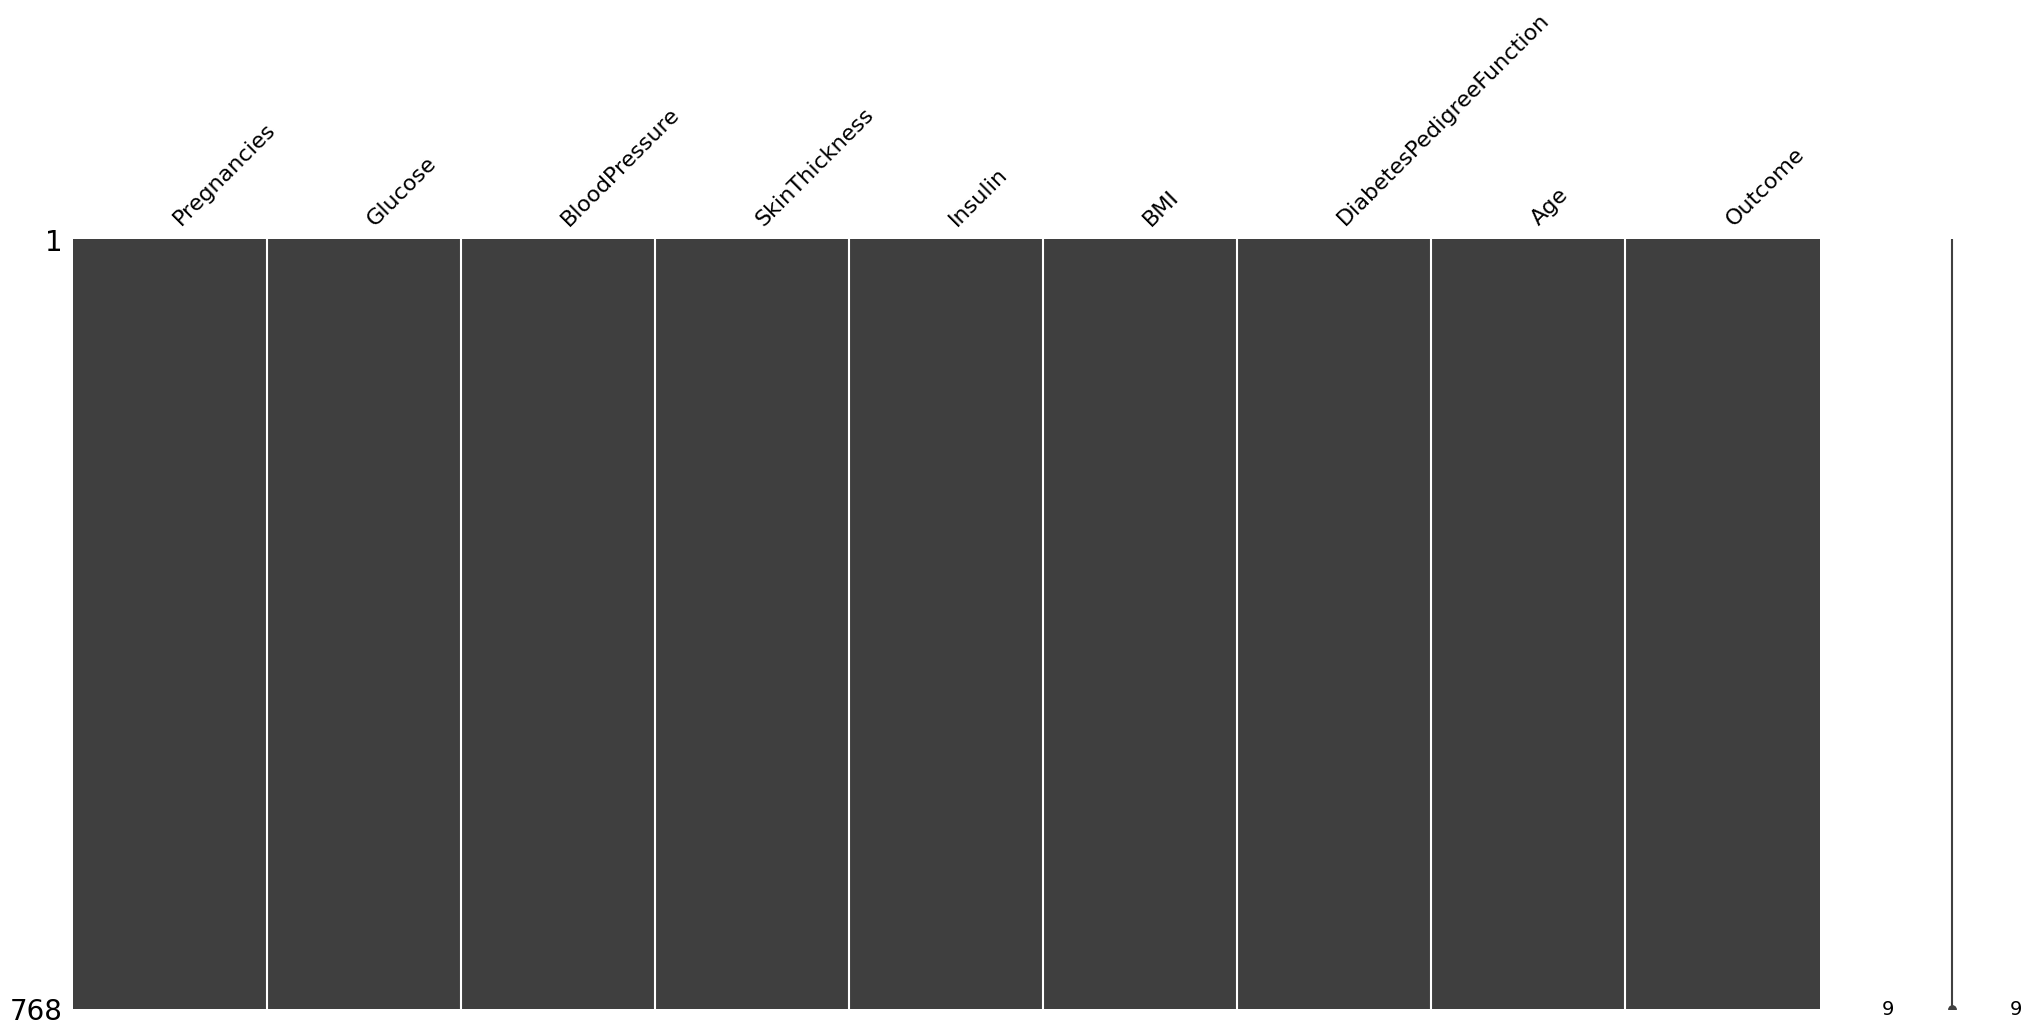

In [11]:
## Check For Nan
missingno.matrix(diabetes_data)

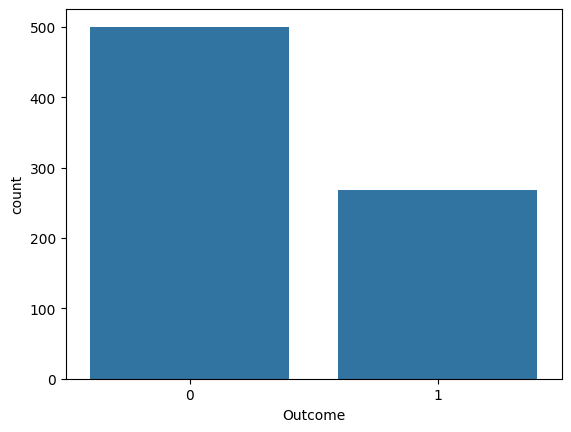

In [12]:
## Check The Target Distrubtion
sns.countplot(data=diabetes_data,x=diabetes_data['Outcome'])
plt.show()

In [13]:
diabetes_data['Outcome'].value_counts(normalize=True) ## Imbalanced Target

Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64

## Data Viz

In [14]:
df.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0


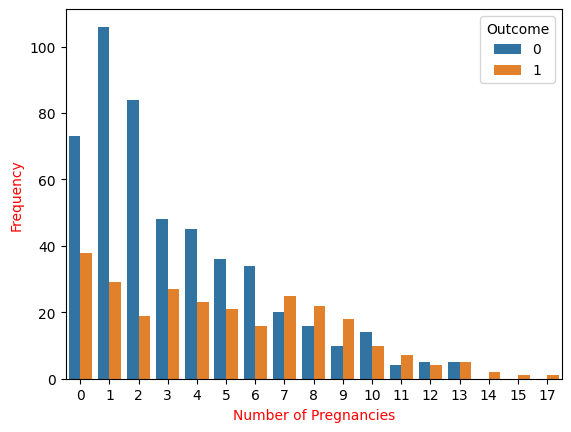

In [15]:
## Countplot of Pregnancies
sns.countplot(data=diabetes_data,x=diabetes_data['Pregnancies'],hue=diabetes_data['Outcome'])
plt.xlabel('Number of Pregnancies',color='r')
plt.ylabel('Frequency',color='r')
plt.show()

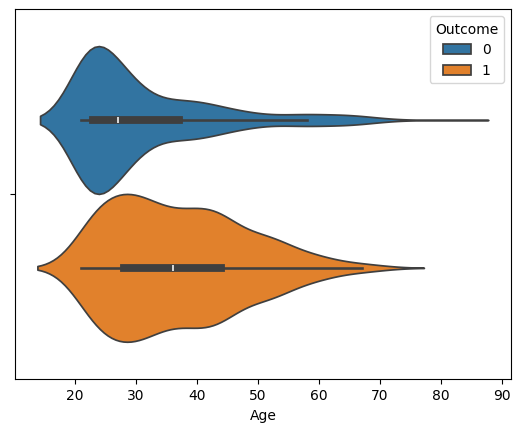

In [16]:
## Relation between Outcome and Age

sns.violinplot(data=diabetes_data,x=diabetes_data['Age'],hue='Outcome')
plt.show()

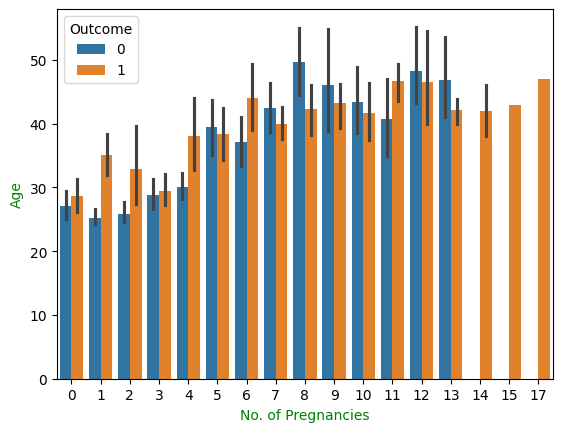

In [17]:
## Pregnancies And Age 
sns.barplot(data=diabetes_data,x='Pregnancies',y='Age',hue='Outcome')
plt.xlabel('No. of Pregnancies',color='g')
plt.ylabel('Age',color='g')
plt.show()

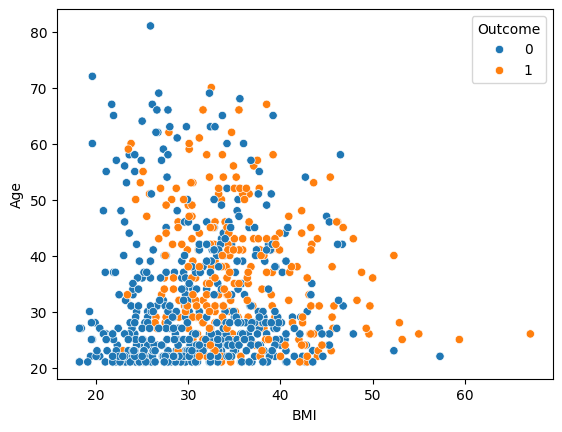

In [18]:
## Scatter Plot of Age And BMI
sns.scatterplot(data=diabetes_data,x='BMI',y='Age',hue='Outcome')
plt.show()


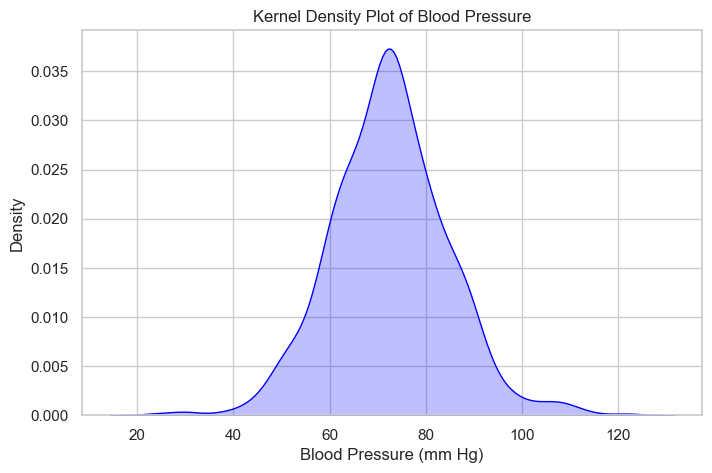

In [19]:

sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.kdeplot(diabetes_data['BloodPressure'], shade=True, color='blue')
plt.xlabel('Blood Pressure (mm Hg)')
plt.ylabel('Density')
plt.title('Kernel Density Plot of Blood Pressure')

plt.show()

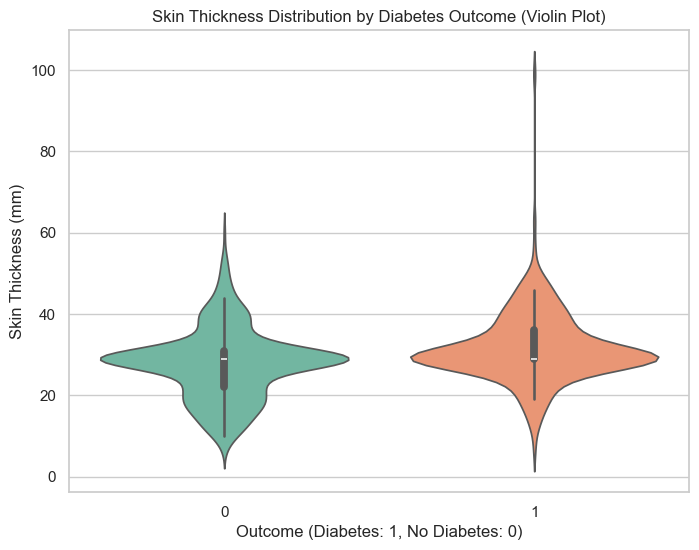

In [20]:
# Create a violin plot for SkinThickness by Outcome
plt.figure(figsize=(8, 6))
sns.violinplot(x='Outcome', y='SkinThickness', data=diabetes_data, palette='Set2')
plt.xlabel('Outcome (Diabetes: 1, No Diabetes: 0)')
plt.ylabel('Skin Thickness (mm)')
plt.title('Skin Thickness Distribution by Diabetes Outcome (Violin Plot)')
plt.show()


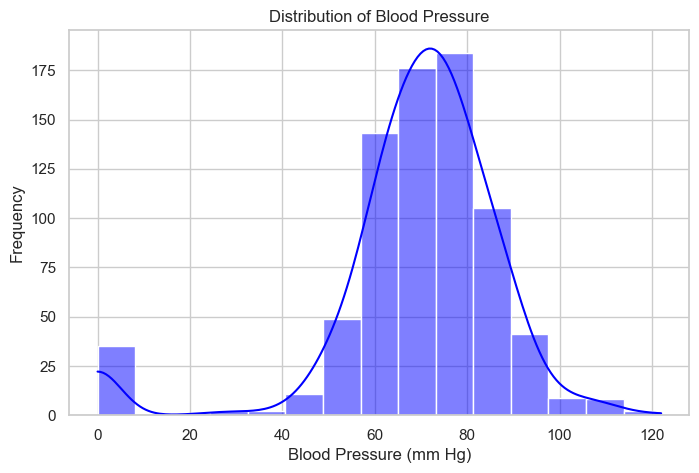

In [21]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.histplot(df['BloodPressure'], bins=15, kde=True, color='blue')
plt.xlabel('Blood Pressure (mm Hg)')
plt.ylabel('Frequency')
plt.title('Distribution of Blood Pressure')
plt.show()

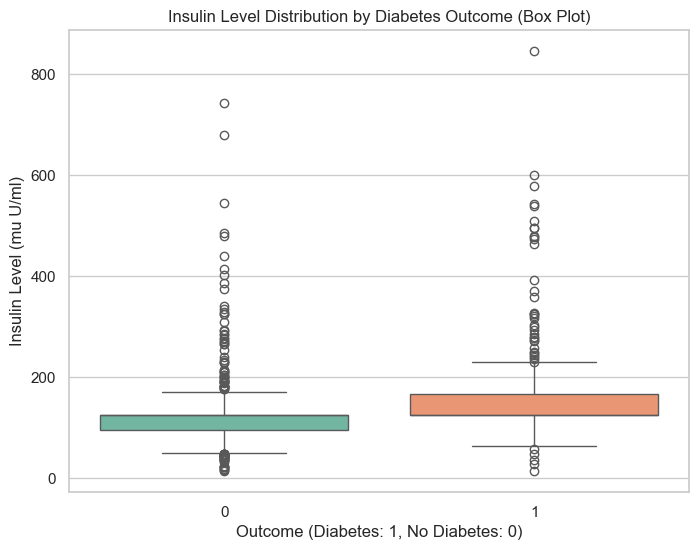

In [22]:
##Insulin Distrubtion by Diabetes
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.boxplot(x='Outcome', y='Insulin', data=diabetes_data, palette='Set2')
plt.xlabel('Outcome (Diabetes: 1, No Diabetes: 0)')
plt.ylabel('Insulin Level (mu U/ml)')
plt.title('Insulin Level Distribution by Diabetes Outcome (Box Plot)')
plt.show()

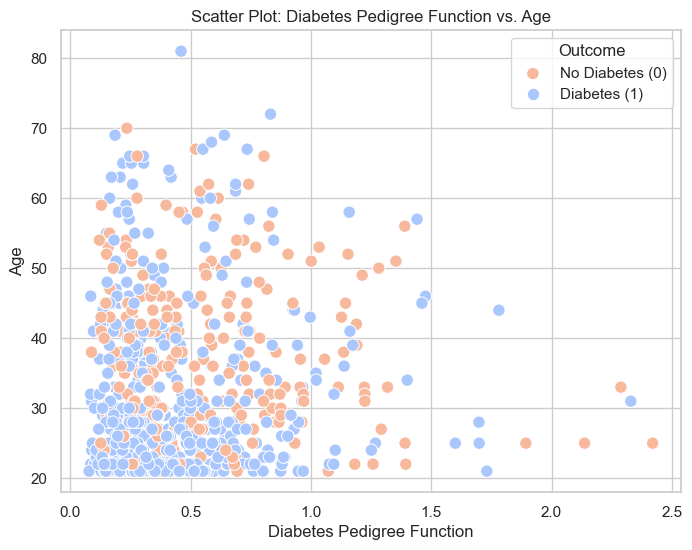

In [23]:
## Scatterplot for Diabetes Pedigree Func vs Age

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.scatterplot(x='DiabetesPedigreeFunction', y='Age', data=df, hue='Outcome', palette='coolwarm', s=80)
plt.xlabel('Diabetes Pedigree Function')
plt.ylabel('Age')
plt.title('Scatter Plot: Diabetes Pedigree Function vs. Age')
plt.legend(title='Outcome', labels=['No Diabetes (0)', 'Diabetes (1)'])
plt.show()

## General View

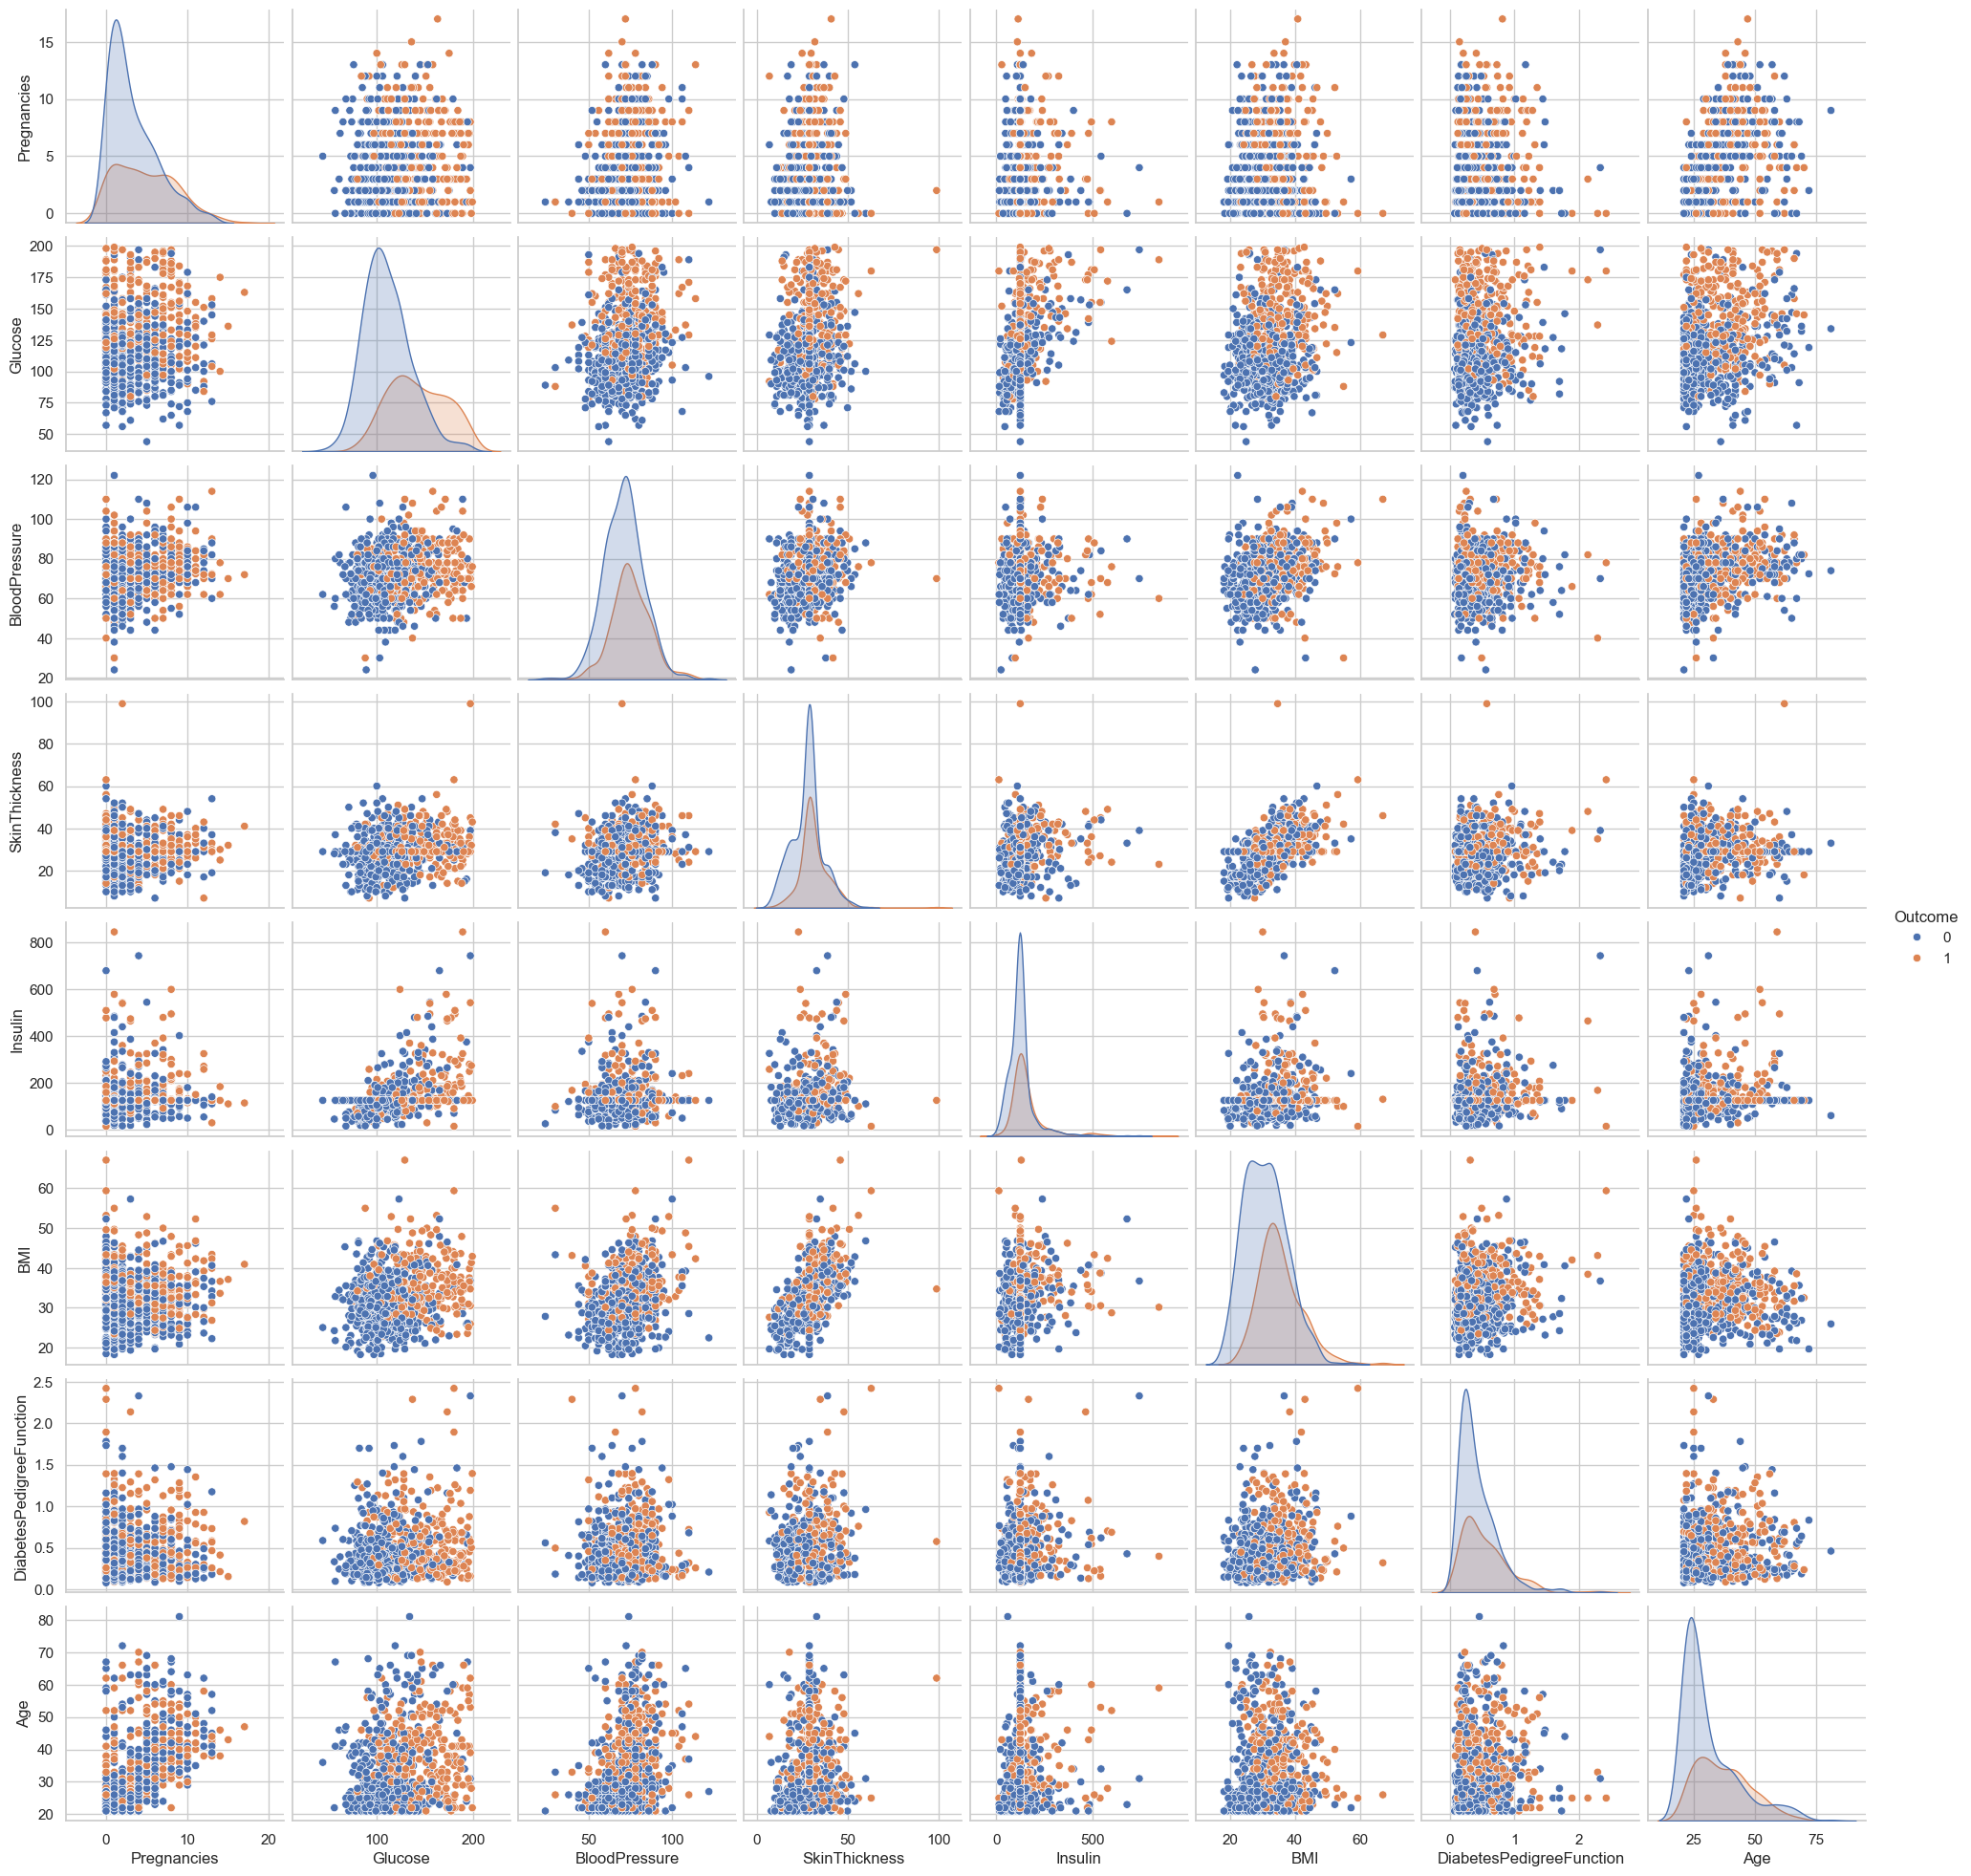

In [24]:
pair=sns.pairplot(data=diabetes_data,hue='Outcome')

## Heatmap

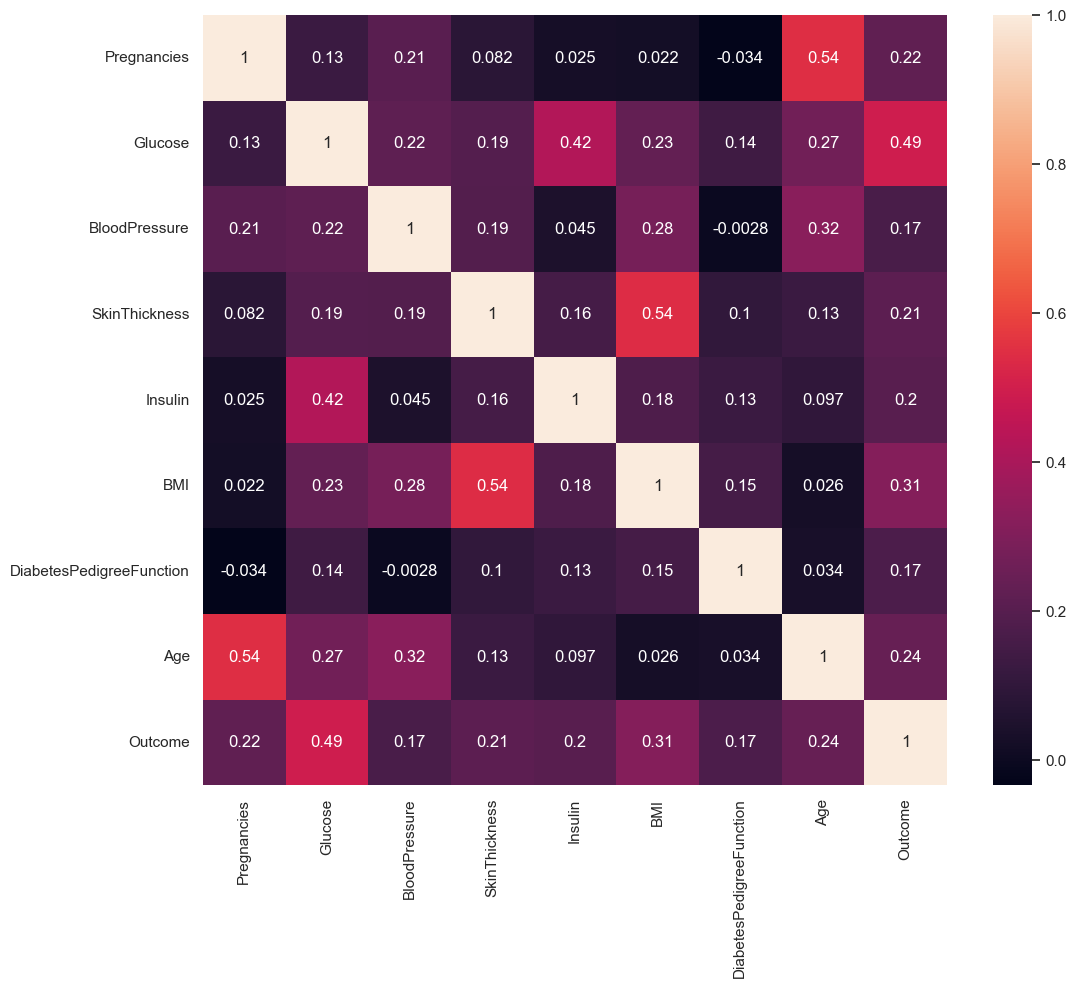

In [25]:
plt.figure(figsize=(12,10))  
sns.heatmap(diabetes_data.corr(), annot=True)  
plt.show()

## Feature Engineering

In [26]:
# Assuming your DataFrame is named "df"
# Define the blood pressure thresholds
normal_threshold = (diabetes_data['BloodPressure'] < 120) & (diabetes_data['BloodPressure'] < 80)
prehypertension_threshold = ((diabetes_data['BloodPressure'] >= 120) & (diabetes_data['BloodPressure'] <= 139)) | ((diabetes_data['BloodPressure'] >= 80) & (diabetes_data['BloodPressure'] <= 89))
hypertension_threshold = (diabetes_data['BloodPressure'] >= 140) | (diabetes_data['BloodPressure'] >= 90)

# Create a new categorical column based on the thresholds
diabetes_data['BloodPressureCategory'] = 'Normal'
diabetes_data.loc[prehypertension_threshold, 'BloodPressureCategory'] = 'Prehypertension'
diabetes_data.loc[hypertension_threshold, 'BloodPressureCategory'] = 'Hypertension'

# Display the updated DataFrame with the new categorical column
print(diabetes_data[['BloodPressure', 'BloodPressureCategory']].head())

   BloodPressure BloodPressureCategory
0           72.0                Normal
1           66.0                Normal
2           64.0                Normal
3           66.0                Normal
4           40.0                Normal


In [27]:
# Define the BMI ranges and categories
bmi_ranges = [0, 18.5, 24.9, 29.9, float('inf')]
bmi_categories = ['Underweight', 'Normal Weight', 'Overweight', 'Obese']

# Create a new categorical column based on BMI ranges
diabetes_data['BMICategory'] = pd.cut(diabetes_data['BMI'], bins=bmi_ranges, labels=bmi_categories, right=False)

# Display the updated DataFrame with the new categorical column
print(diabetes_data[['BMI', 'BMICategory']].head())



    BMI    BMICategory
0  33.6          Obese
1  26.6     Overweight
2  23.3  Normal Weight
3  28.1     Overweight
4  43.1          Obese


In [28]:

# Apply a logarithmic transformation to the "Insulin" feature
diabetes_data['Log_Insulin'] = np.log1p(diabetes_data['Insulin'])

# Apply a logarithmic transformation to the "SkinThickness" feature
diabetes_data['Log_SkinThickness'] = np.log1p(diabetes_data['SkinThickness'])

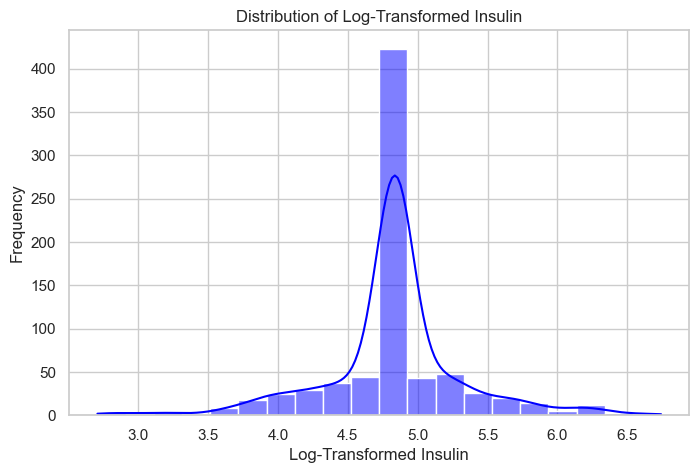

In [29]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

# Create a histogram for log-transformed data
sns.histplot(diabetes_data['Log_Insulin'], bins=20, kde=True, color='blue')

# Add labels and a title
plt.xlabel('Log-Transformed Insulin')
plt.ylabel('Frequency')
plt.title('Distribution of Log-Transformed Insulin')

# Show the plot
plt.show()








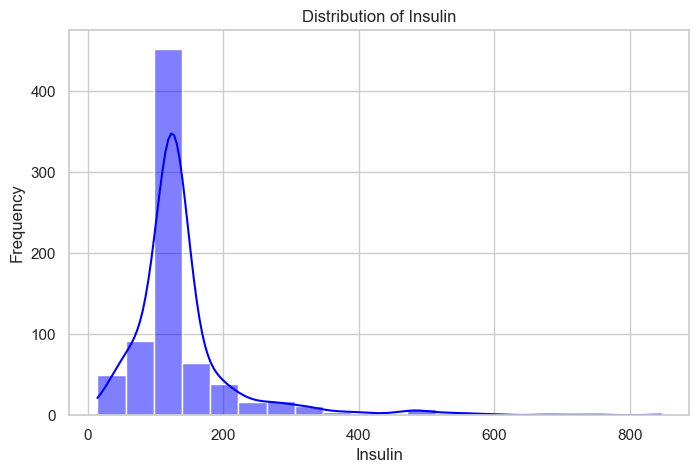

In [30]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

# Create a histogram for log-transformed data
sns.histplot(diabetes_data['Insulin'], bins=20, kde=True, color='blue')

# Add labels and a title
plt.xlabel('Insulin')
plt.ylabel('Frequency')
plt.title('Distribution of Insulin')

# Show the plot
plt.show()


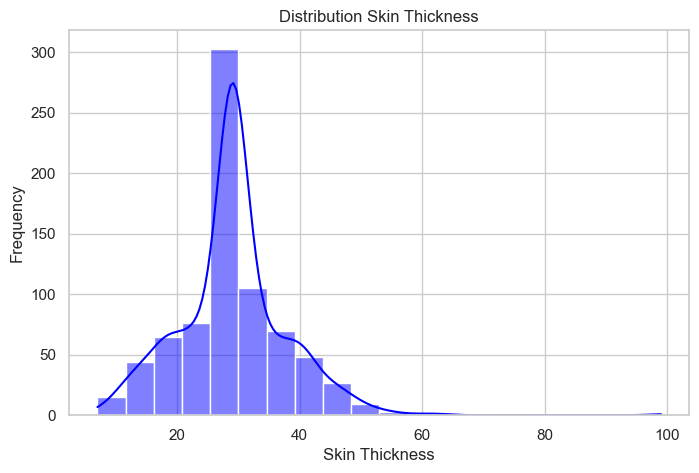

In [31]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

# Create a histogram for log-transformed data
sns.histplot(diabetes_data['SkinThickness'], bins=20, kde=True, color='blue')

# Add labels and a title
plt.xlabel('Skin Thickness')
plt.ylabel('Frequency')
plt.title('Distribution Skin Thickness')

# Show the plot
plt.show()

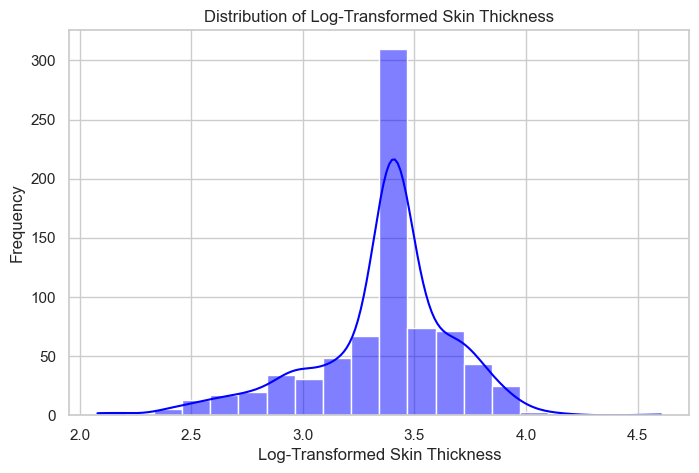

In [32]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

# Create a histogram for log-transformed data
sns.histplot(diabetes_data['Log_SkinThickness'], bins=20, kde=True, color='blue')

# Add labels and a title
plt.xlabel('Log-Transformed Skin Thickness')
plt.ylabel('Frequency')
plt.title('Distribution of Log-Transformed Skin Thickness')

# Show the plot
plt.show()

## Data Preprocesing

In [33]:
## to features and target
X = diabetes_data.drop(columns=['Outcome'], axis=1)
y = diabetes_data['Outcome']


## split to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=45, stratify=y)

print('X_train.shape \t', X_train.shape)
print('y_train.shape \t', y_train.shape)
print('**'*20)
print('X_test.shape \t', X_test.shape)
print('y_test.shape \t', y_test.shape)

X_train.shape 	 (614, 12)
y_train.shape 	 (614,)
****************************************
X_test.shape 	 (154, 12)
y_test.shape 	 (154,)


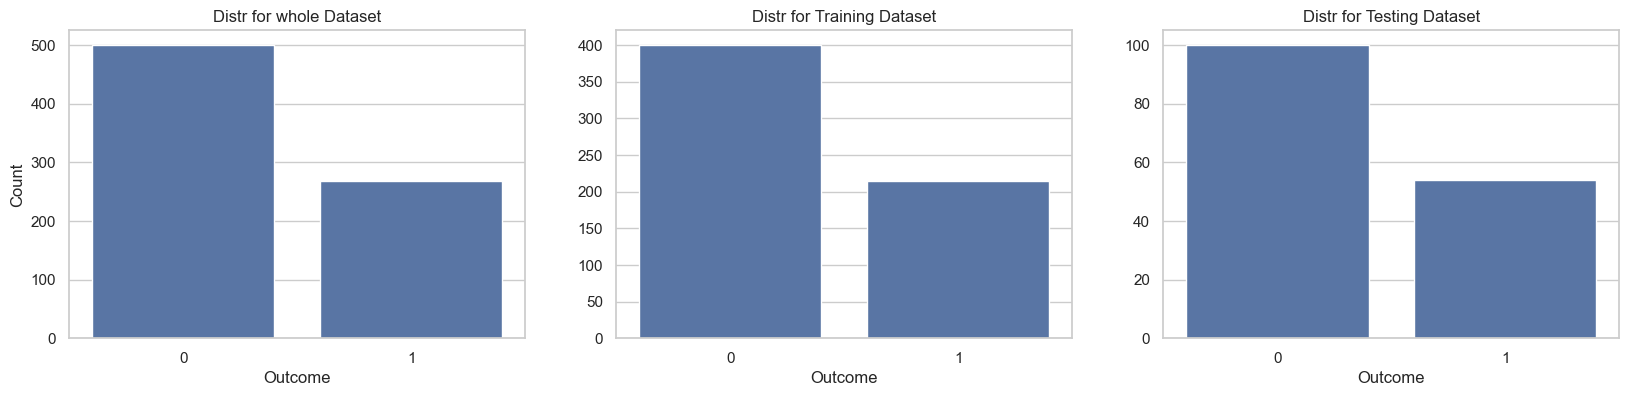

In [34]:
## Check the distr of target in train and test
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

## for full data
plt.sca(ax[0])
sns.countplot(x=y)
plt.title('Distr for whole Dataset')
plt.ylabel('Count')

## for Training data
plt.sca(ax[1])
sns.countplot(x=y_train)
plt.title('Distr for Training Dataset')
plt.ylabel('')


## for Testing  data
plt.sca(ax[2])
sns.countplot(x=y_test)
plt.title('Distr for Testing Dataset')
plt.ylabel('')
plt.show()

## Pipeline

In [35]:
num_cols = ['Age', 'Pregnancies', 'BloodPressure', 'SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Glucose','Log_Insulin','Log_SkinThickness']
categ_cols = X_train.select_dtypes(exclude='number').columns.tolist()
print(categ_cols)
print(num_cols)

['BloodPressureCategory', 'BMICategory']
['Age', 'Pregnancies', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Glucose', 'Log_Insulin', 'Log_SkinThickness']


In [36]:
num_pipline = Pipeline(steps=[
                ('selector', DataFrameSelector(num_cols)),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ])

## Categorical
categ_pipline = Pipeline(steps=[
                 ('selector', DataFrameSelector(categ_cols)),
                 ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(drop='first', sparse_output=False))
])

all_pipeline = FeatureUnion(transformer_list=[
                        ('num', num_pipline),
                        ('categ', categ_pipline)
                    ])

## apply
X_train_final  = all_pipeline.fit_transform(X_train)
X_test_final = all_pipeline.transform(X_test)

In [37]:
print('X_train_final.shape \t', X_train_final.shape)
print('y_train.shape \t', y_train.shape)
print('**'*20)
print('X_test_final.shape \t', X_test_final.shape)
print('y_test.shape \t', y_test.shape)  ## fine

X_train_final.shape 	 (614, 15)
y_train.shape 	 (614,)
****************************************
X_test_final.shape 	 (154, 15)
y_test.shape 	 (154,)


## Imbalanced Target

In [38]:
## 2. SMOTE
over = SMOTE(sampling_strategy=0.7)
X_train_resampled, y_train_resampled = over.fit_resample(X_train_final, y_train)  ## for train

y_train_resampled.value_counts(), y_train.value_counts()

(Outcome
 0    400
 1    280
 Name: count, dtype: int64,
 Outcome
 0    400
 1    214
 Name: count, dtype: int64)

## Building Models

## 1.RF

In [39]:
## 1. Without taking into consideration the imbalancing of dataset
forst_clf = RandomForestClassifier(n_estimators=150, max_depth=5, random_state=45)
forst_clf.fit(X_train_final, y_train)

## Predict and evaluate 
y_pred_train_forest = forst_clf.predict(X_train_final)
y_pred_test_forest = forst_clf.predict(X_test_final)

## Evaluate
score_train_forest = f1_score(y_train, y_pred_train_forest)
score_test_forest = f1_score(y_test, y_pred_test_forest)

print(f'Score for Training Dataset using RF without solve imbalancing {score_train_forest * 100 :.3f}')
print(f'Score for Testing Dataset using RF without solve imbalancing {score_test_forest * 100 :.3f}')

Score for Training Dataset using RF without solve imbalancing 74.406
Score for Testing Dataset using RF without solve imbalancing 63.636


In [40]:
## 2. with take into consideration the imbalancing using (over sampled using SMOTE) 
forst_clf = RandomForestClassifier(n_estimators=150, max_depth=5, random_state=45)
forst_clf.fit(X_train_resampled, y_train_resampled)

## Predict and evaluate 
y_pred_train_forest = forst_clf.predict(X_train_final)
y_pred_test_forest = forst_clf.predict(X_test_final)

## Evaluate
score_train_forest = f1_score(y_train, y_pred_train_forest)
score_test_forest = f1_score(y_test, y_pred_test_forest)

print(f'Score for Training Dataset using RF after SMOTE {score_train_forest * 100 :.3f}')
print(f'Score for Testing Dataset using RF after SMOTE {score_test_forest * 100 :.3f}')

Score for Training Dataset using RF after SMOTE 80.000
Score for Testing Dataset using RF after SMOTE 66.000


## 2.KNN

In [42]:
## Using knn using SMOTE Approach
knn_clf = KNeighborsClassifier(n_neighbors=3, p=2,weights='distance')
knn_clf.fit(X_train_resampled, y_train_resampled)

## Predict and evaluate 
y_pred_train_knn = knn_clf.predict(X_train_final)
y_pred_test_knn = knn_clf.predict(X_test_final)

## Evaluate
score_train_knn = f1_score(y_train, y_pred_train_knn)
score_test_knn = f1_score(y_test, y_pred_test_knn)

print(f'Score for Training Dataset using KNN after SMOTE {score_train_knn * 100 :.3f}')
print(f'Score for Testing Dataset using KNN after SMOTE {score_test_knn * 100 :.3f}')

Score for Training Dataset using KNN after SMOTE 100.000
Score for Testing Dataset using KNN after SMOTE 61.404


## 3.XGB

In [43]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic',eval_metric='logloss',learning_rate=1, max_depth=5,n_estimators=100, random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)

## Predict and evaluate 
y_pred_train_xg= xgb_model.predict(X_train_final)
y_pred_test_xg= xgb_model.predict(X_test_final)

## Evaluate
score_train_xgb= f1_score(y_train, y_pred_train_xg)
score_test_xgb = f1_score(y_test, y_pred_test_xg)

print(f'Score for Training Dataset using XGBOOST after SMOTE {score_train_xgb * 100 :.3f}')
print(f'Score for Testing Dataset using XGBOOST after SMOTE {score_test_xgb * 100 :.3f}')

Score for Training Dataset using XGBOOST after SMOTE 100.000
Score for Testing Dataset using XGBOOST after SMOTE 62.136


## Hyperparameter Tuning

In [ ]:

# Create a KNN classifier
knn = KNeighborsClassifier()

# Define a dictionary of hyperparameters and their possible values to search
param_grid = {
    'n_neighbors':np.arange(8,20),  # Number of neighbors to consider
    'weights': ['uniform', 'distance'],  # Weighting strategy
    'p': [1, 2],  # Power parameter for Minkowski distance (1 for Manhattan, 2 for Euclidean)
    'metric':['minkowski','manhattan','euclidean']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to your data
grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best hyperparameters and the corresponding cross-validated score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Best Hyperparameters: {'metric': 'minkowski', 'n_neighbors': 11, 'p': 1, 'weights': 'distance'}
Best Score: 0.7705882352941177


In [45]:
## KNN After tuning
knn_clf = KNeighborsClassifier(n_neighbors=10, p=2,weights='distance',metric='minkowski')
knn_clf.fit(X_train_resampled, y_train_resampled)

## Predict and evaluate 
y_pred_train_knn = knn_clf.predict(X_train_final)
y_pred_test_knn = knn_clf.predict(X_test_final)

## Evaluate
score_train_knn = f1_score(y_train, y_pred_train_knn)
score_test_knn = f1_score(y_test, y_pred_test_knn)

print(f'Score for Training Dataset using KNN after SMOTE {score_train_knn * 100 :.3f}')
print(f'Score for Testing Dataset using KNN after SMOTE {score_test_knn * 100 :.3f}')


Score for Training Dataset using KNN after SMOTE 100.000
Score for Testing Dataset using KNN after SMOTE 67.961


## Evaluatin Metrics

## Confusion Metric

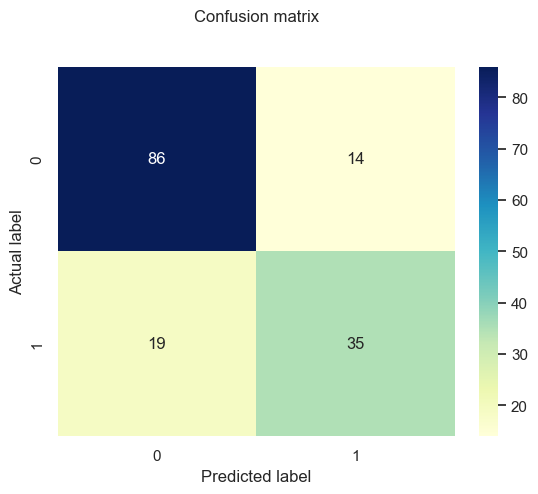

In [46]:
y_pred = knn_clf.predict(X_test_final)
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## Classfication Report

In [47]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       100
           1       0.71      0.65      0.68        54

    accuracy                           0.79       154
   macro avg       0.77      0.75      0.76       154
weighted avg       0.78      0.79      0.78       154



## ROC

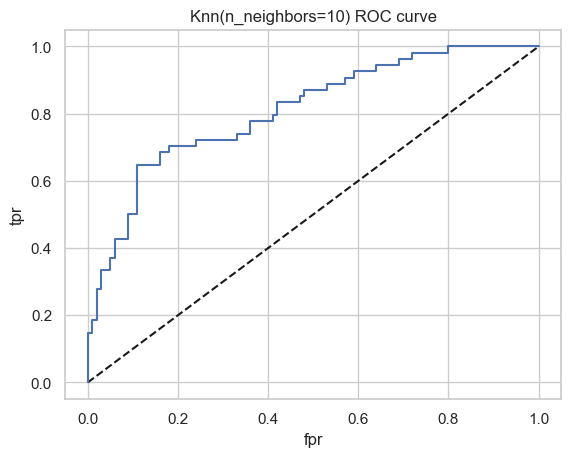

In [48]:
from sklearn.metrics import roc_curve
y_pred_proba = knn_clf.predict_proba(X_test_final)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=10) ROC curve')
plt.show()

In [ ]:
joblib.dump(knn_clf, 'knn_model.pkl') 

['knn_model.pkl']